In [17]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import seaborn as sns

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import cv2

In [18]:
img_path_list = []

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))

In [19]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

Top_path = './data/box_img/Top/'
Bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [20]:
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


각 컬러스페이스로 나열 및 저장

In [21]:
top_avg_rgb = []
bot_avg_rgb = []
top_avg_yuv = []
bot_avg_yuv = []
top_avg_hsv = []
bot_avg_hsv = []
top_avg_lab = []
bot_avg_lab = []
top_avg_hls = []
bot_avg_hls = []

# opencv는 imread로 읽으면 default로 BGR순서임
for i in range(len(img_path_list)):
    top = cv2.imread(Top_path + 'Top_{}.jpg'.format(i))
    bot = cv2.imread(Bot_path + 'Bot_{}.jpg'.format(i))

    # 컬러스페이스 변환
    top_rgb = cv2.cvtColor(top, cv2.COLOR_BGR2RGB)
    bot_rgb = cv2.cvtColor(bot, cv2.COLOR_BGR2RGB)

    top_yuv = cv2.cvtColor(top, cv2.COLOR_BGR2YUV)
    bot_yuv = cv2.cvtColor(bot, cv2.COLOR_BGR2YUV)
    
    top_hsv = cv2.cvtColor(top, cv2.COLOR_BGR2HSV)
    bot_hsv = cv2.cvtColor(bot, cv2.COLOR_BGR2HSV)

    top_lab = cv2.cvtColor(top, cv2.COLOR_BGR2Lab)
    bot_lab = cv2.cvtColor(bot, cv2.COLOR_BGR2Lab)

    top_hls = cv2.cvtColor(top, cv2.COLOR_BGR2HLS)
    bot_hls = cv2.cvtColor(bot, cv2.COLOR_BGR2HLS)

    # 평균값 계산
    top_avg_rgb.append(np.mean(top_rgb, axis=(0, 1)))
    bot_avg_rgb.append(np.mean(bot_rgb, axis=(0, 1)))

    top_avg_yuv.append(np.mean(top_yuv, axis=(0, 1)))
    bot_avg_yuv.append(np.mean(bot_yuv, axis=(0, 1)))

    top_avg_hsv.append(np.mean(top_hsv, axis=(0, 1)))
    bot_avg_hsv.append(np.mean(bot_hsv, axis=(0, 1)))

    top_avg_lab.append(np.mean(top_lab, axis=(0, 1)))
    bot_avg_lab.append(np.mean(bot_lab, axis=(0, 1)))

    top_avg_hls.append(np.mean(top_hls, axis=(0, 1)))
    bot_avg_hls.append(np.mean(bot_hls, axis=(0, 1)))
    
    

In [22]:
Table_dataset = pd.DataFrame({
    'Top_RGB_R' : [i[0] for i in top_avg_rgb], 
    'Top_RGB_G' : [i[1] for i in top_avg_rgb], 
    'Top_RGB_B' : [i[2] for i in top_avg_rgb],

    'Bot_RGB_R' : [i[0] for i in bot_avg_rgb], 
    'Bot_RGB_G' : [i[1] for i in bot_avg_rgb], 
    'Bot_RGB_B' : [i[2] for i in bot_avg_rgb],

    'Top_YUV_Y' : [i[0] for i in top_avg_yuv], 
    'Top_YUV_U' : [i[1] for i in top_avg_yuv], 
    'Top_YUV_V' : [i[2] for i in top_avg_yuv],

    'Bot_YUV_Y' : [i[0] for i in bot_avg_yuv], 
    'Bot_YUV_U' : [i[1] for i in bot_avg_yuv], 
    'Bot_YUV_V' : [i[2] for i in bot_avg_yuv],

    'Top_HSV_H' : [i[0] for i in top_avg_hsv], 
    'Top_HSV_S' : [i[1] for i in top_avg_hsv], 
    'Top_HSV_V' : [i[2] for i in top_avg_hsv],

    'Bot_HSV_H' : [i[0] for i in bot_avg_hsv], 
    'Bot_HSV_S' : [i[1] for i in bot_avg_hsv], 
    'Bot_HSV_V' : [i[2] for i in bot_avg_hsv],

    'Top_LAB_L' : [i[0] for i in top_avg_lab], 
    'Top_LAB_A' : [i[1] for i in top_avg_lab], 
    'Top_LAB_B' : [i[2] for i in top_avg_lab],

    'Bot_LAB_L' : [i[0] for i in bot_avg_lab], 
    'Bot_LAB_A' : [i[1] for i in bot_avg_lab], 
    'Bot_LAB_B' : [i[2] for i in bot_avg_lab],

    'Top_hls_H' : [i[0] for i in top_avg_hls], 
    'Top_hls_L' : [i[1] for i in top_avg_hls], 
    'Top_hls_S' : [i[2] for i in top_avg_hls],

    'Bot_hls_H' : [i[0] for i in bot_avg_hls], 
    'Bot_hls_L' : [i[1] for i in bot_avg_hls], 
    'Bot_hls_S' : [i[2] for i in bot_avg_hls],

    'Thickness': Thickness['Thickness']
})


열 개수 : 5x3x2+1

In [23]:
Table_dataset

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Bot_RGB_R,Bot_RGB_G,Bot_RGB_B,Top_YUV_Y,Top_YUV_U,Top_YUV_V,Bot_YUV_Y,...,Bot_LAB_L,Bot_LAB_A,Bot_LAB_B,Top_hls_H,Top_hls_L,Top_hls_S,Bot_hls_H,Bot_hls_L,Bot_hls_S,Thickness
0,11.5760,10.8832,8.1364,30.2140,37.7740,50.4468,10.8832,126.6404,128.6928,37.0204,...,37.9392,128.6176,118.6128,22.0552,10.0796,48.2524,108.7624,40.5660,64.2544,48.266667
1,12.4712,12.6248,11.2136,25.9992,34.8912,43.0424,12.5096,127.3584,127.9616,33.1272,...,33.6496,126.7188,121.4292,23.5584,11.9808,19.2812,104.2764,34.6176,63.2720,47.966667
2,12.7704,12.7176,9.9168,31.3148,35.7876,41.8260,12.5384,126.7120,128.2320,35.1444,...,35.5236,127.6692,123.3704,29.7648,11.5876,36.0004,107.4464,36.5932,36.9364,48.166667
3,11.2308,11.4564,8.8540,24.8812,32.4324,39.4952,11.1748,126.9128,128.0560,31.0332,...,30.6900,126.8772,122.1940,26.6792,10.3208,38.6628,104.4104,32.3344,58.2892,48.600000
4,5.4696,3.2120,1.4352,26.0116,32.5420,38.0564,3.6852,126.9400,129.7764,31.2852,...,30.9328,126.7972,123.3564,30.1924,3.4992,183.6056,104.3064,32.1788,48.6532,59.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,27.1852,35.2252,42.7796,5.6392,136.0872,123.6048,33.7116,...,34.1420,126.8716,121.8764,113.7296,11.4400,242.9364,104.5120,35.0452,57.1976,84.633333
123,0.8864,15.7112,33.7552,28.0672,35.4464,40.1680,13.3292,137.8364,117.1652,33.8656,...,34.2668,126.1560,123.8784,106.4372,17.3900,242.7924,101.4032,34.2116,45.6000,98.366667
124,1.0244,13.5756,38.8264,27.8880,36.0608,43.8560,12.6764,140.7024,117.6448,34.4976,...,35.1864,126.8108,121.7164,110.2024,19.9424,242.7808,104.6304,35.9388,57.2016,97.033333
125,1.1264,13.7168,35.3488,30.6892,36.6848,45.9800,12.3548,139.0512,117.9476,35.9440,...,36.5716,128.1388,120.9752,108.9280,18.2620,240.7560,108.3436,38.4196,51.2932,96.266667


csv저장

In [24]:
Table_dataset.to_csv('./data/colorspace_tras.csv', index=False)


컬럼명들

In [25]:
print(Table_dataset.columns)

Index(['Top_RGB_R', 'Top_RGB_G', 'Top_RGB_B', 'Bot_RGB_R', 'Bot_RGB_G',
       'Bot_RGB_B', 'Top_YUV_Y', 'Top_YUV_U', 'Top_YUV_V', 'Bot_YUV_Y',
       'Bot_YUV_U', 'Bot_YUV_V', 'Top_HSV_H', 'Top_HSV_S', 'Top_HSV_V',
       'Bot_HSV_H', 'Bot_HSV_S', 'Bot_HSV_V', 'Top_LAB_L', 'Top_LAB_A',
       'Top_LAB_B', 'Bot_LAB_L', 'Bot_LAB_A', 'Bot_LAB_B', 'Top_hls_H',
       'Top_hls_L', 'Top_hls_S', 'Bot_hls_H', 'Bot_hls_L', 'Bot_hls_S',
       'Thickness'],
      dtype='object')


### 분석된 상위 특징 조합

다음의 컬러 공간에서 높은 상관도를 보인 특징들을 이용해 분석을 진행

- **RGB** 컬러 공간에서의 특징들:
  - **R (빨강)**
  - **G (초록)**
  - **B (파랑)**

- **YUV** 컬러 공간에서의 특징들:
  - **Y (밝기)**
  - **V (빨강색 - 밝기)**


- **HSV** 컬러 공간에서의 특징들:
  - **V (명도)**


- **LAB** 컬러 공간에서의 특징들:
  - **L (밝기)**
  - **A (적록)**

- **hls** 컬러 공간에서의 특징들:
  - **S (채도)**


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Hsl-hsv_models.svg/290px-Hsl-hsv_models.svg.png" width="250" />

hls (for hue, saturation, lightness) and HSV (for hue, saturation, value
)

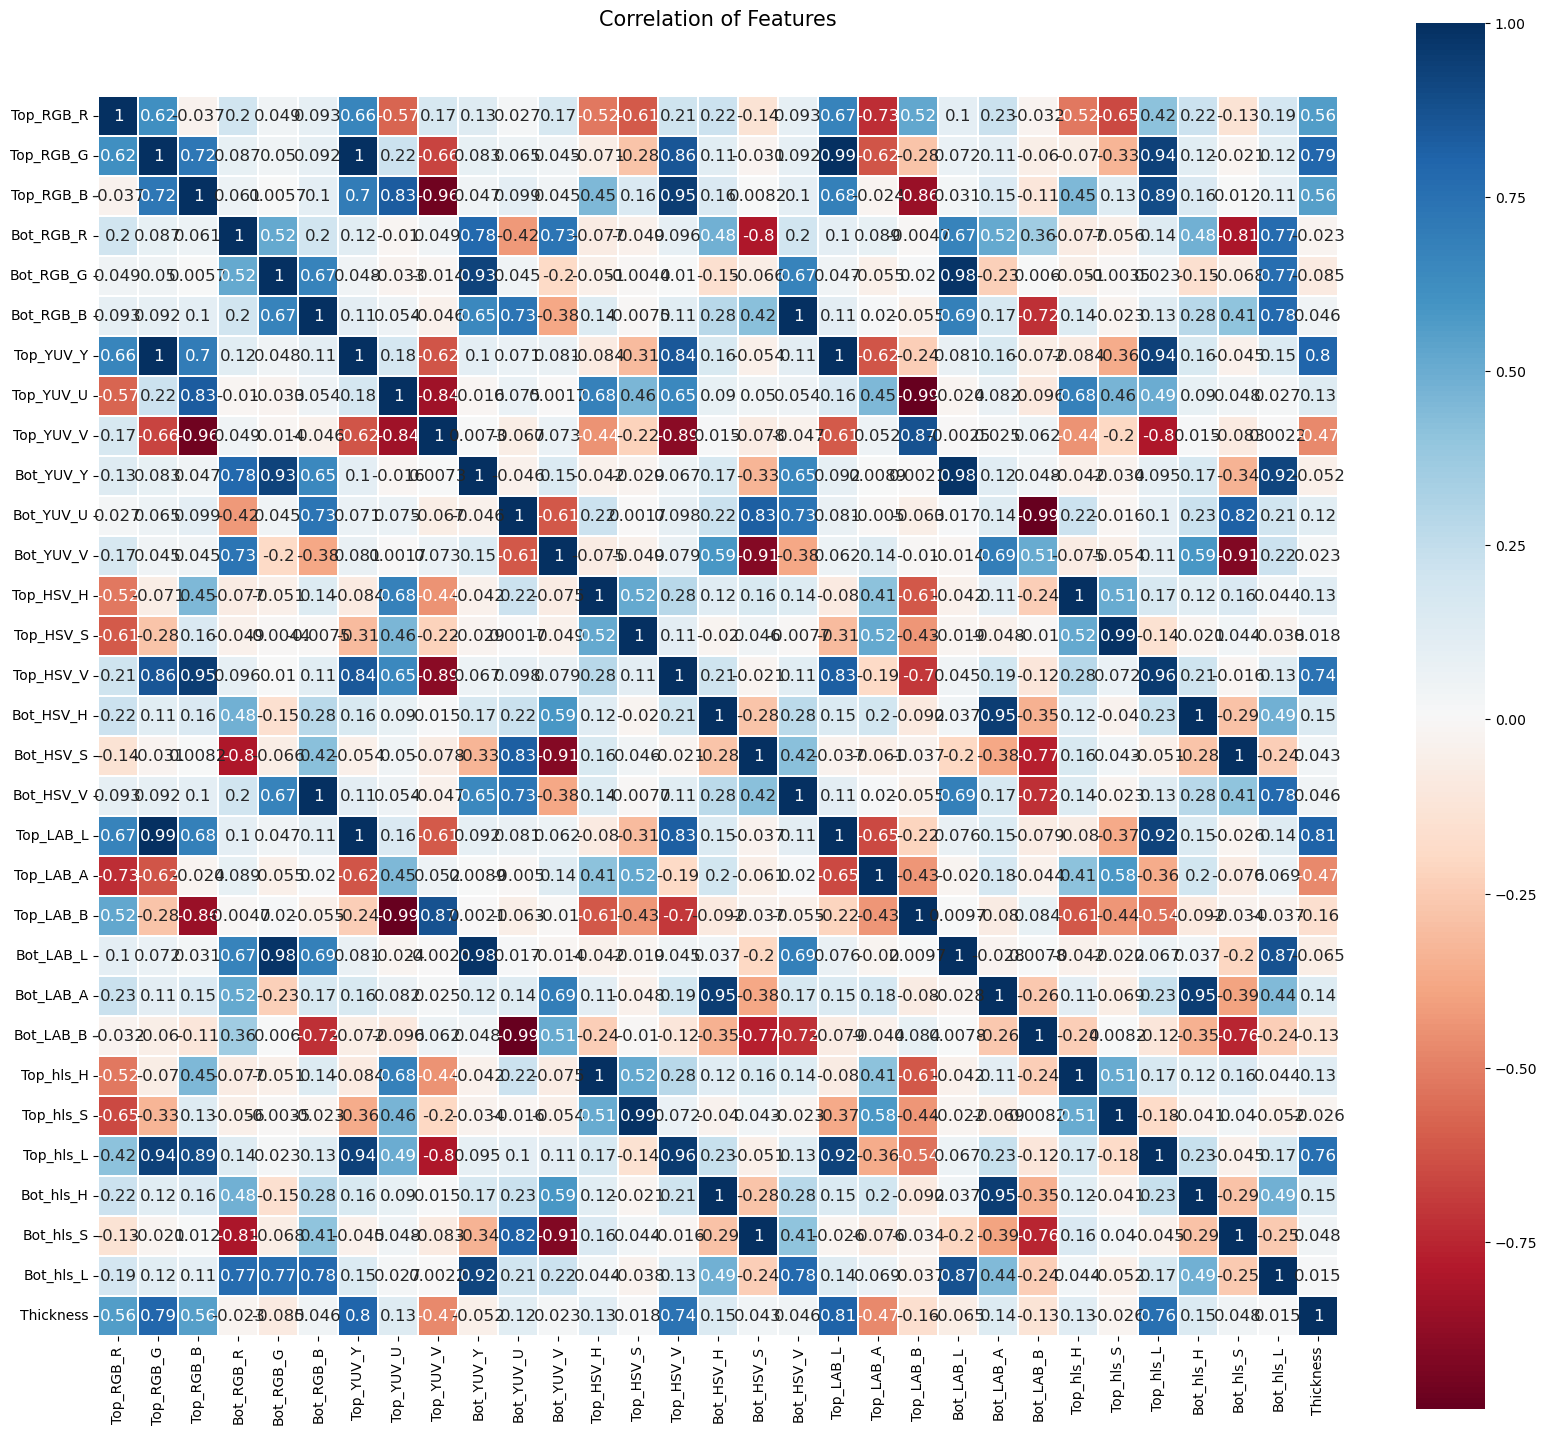

In [26]:
heatmap_data = Table_dataset[['Top_RGB_R', 'Top_RGB_G', 'Top_RGB_B', 
                              'Bot_RGB_R', 'Bot_RGB_G', 'Bot_RGB_B',
                              'Top_YUV_Y', 'Top_YUV_U', 'Top_YUV_V',
                              'Bot_YUV_Y', 'Bot_YUV_U', 'Bot_YUV_V',
                              'Top_HSV_H', 'Top_HSV_S', 'Top_HSV_V',
                              'Bot_HSV_H', 'Bot_HSV_S', 'Bot_HSV_V',
                              'Top_LAB_L', 'Top_LAB_A','Top_LAB_B', 
                              'Bot_LAB_L', 'Bot_LAB_A', 'Bot_LAB_B', 
                              'Top_hls_H','Top_hls_S', 'Top_hls_L',
                              'Bot_hls_H', 'Bot_hls_S', 'Bot_hls_L',
                             'Thickness']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(20, 18))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 12})

del heatmap_data


히트맵은 feature들과 label의 선형 상관도를 나타냈습니다.

trial1

In [27]:
trial1_Table_dataset = Table_dataset.drop([
                                          'Bot_RGB_R', 'Bot_RGB_G', 'Bot_RGB_B',
                                                       'Top_YUV_U', 
                                          'Bot_YUV_Y', 'Bot_YUV_U', 'Bot_YUV_V',
                                          'Top_HSV_H', 'Top_HSV_S', 
                                          'Bot_HSV_H', 'Bot_HSV_S', 'Bot_HSV_V',
                                                                    'Top_LAB_B', 
                                          'Bot_LAB_L', 'Bot_LAB_A', 'Bot_LAB_B', 
                                          'Top_hls_H',              'Top_hls_L',
                                          'Bot_hls_H', 'Bot_hls_S', 'Bot_hls_L',
                                           ],axis=1)
trial1_Table_dataset

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Top_YUV_Y,Top_YUV_V,Top_HSV_V,Top_LAB_L,Top_LAB_A,Top_hls_S,Thickness
0,11.5760,10.8832,8.1364,10.8832,128.6928,11.5760,7.9380,127.7256,48.2524,48.266667
1,12.4712,12.6248,11.2136,12.5096,127.9616,12.7416,9.1360,127.8464,19.2812,47.966667
2,12.7704,12.7176,9.9168,12.5384,128.2320,12.9592,9.1536,127.7216,36.0004,48.166667
3,11.2308,11.4564,8.8540,11.1748,128.0560,11.6148,8.1944,127.6992,38.6628,48.600000
4,5.4696,3.2120,1.4352,3.6852,129.7764,5.5860,2.1696,128.2872,183.6056,59.533333
...,...,...,...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,5.6392,123.6048,22.1704,4.0708,130.0016,242.9364,84.633333
123,0.8864,15.7112,33.7552,13.3292,117.1652,33.7552,11.0660,128.8264,242.7924,98.366667
124,1.0244,13.5756,38.8264,12.6764,117.6448,38.8264,10.5144,132.0096,242.7808,97.033333
125,1.1264,13.7168,35.3488,12.3548,117.9476,35.3488,10.2208,130.4280,240.7560,96.266667


In [28]:
print(trial1_Table_dataset.columns)

Index(['Top_RGB_R', 'Top_RGB_G', 'Top_RGB_B', 'Top_YUV_Y', 'Top_YUV_V',
       'Top_HSV_V', 'Top_LAB_L', 'Top_LAB_A', 'Top_hls_S', 'Thickness'],
      dtype='object')


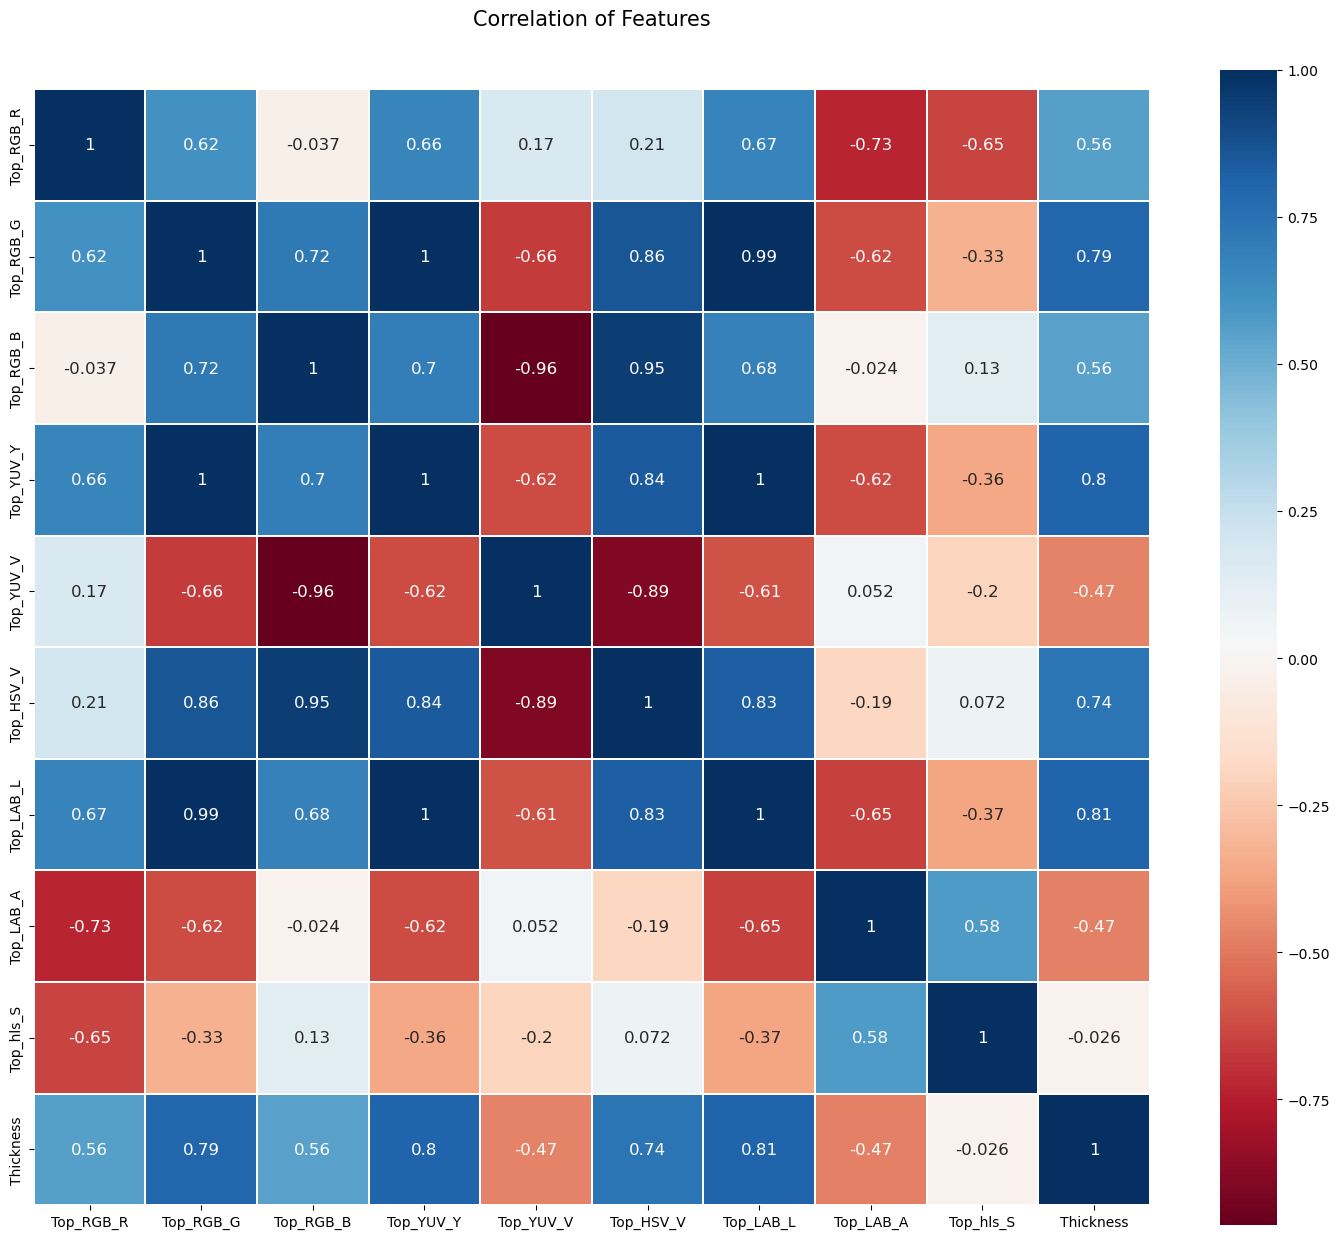

In [29]:
heatmap_data = trial1_Table_dataset[[
    'Top_RGB_R', 'Top_RGB_G', 'Top_RGB_B', 'Top_YUV_Y', 'Top_YUV_V',
    'Top_HSV_V', 'Top_LAB_L', 'Top_LAB_A', 'Top_hls_S', 'Thickness']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(18, 15))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 12})

del heatmap_data


LAB_A와 YUV_V는 같으니 Top_LAB_A는 제외함

In [30]:
trial1_Table_dataset = trial1_Table_dataset.drop(['Top_LAB_A'] ,axis=1)
trial1_Table_dataset

,Top_RGB_R,Top_RGB_G,Top_RGB_B,Top_YUV_Y,Top_YUV_V,Top_HSV_V,Top_LAB_L,Top_hls_S,Thickness
0,11.5760,10.8832,8.1364,10.8832,128.6928,11.5760,7.9380,48.2524,48.266667
1,12.4712,12.6248,11.2136,12.5096,127.9616,12.7416,9.1360,19.2812,47.966667
2,12.7704,12.7176,9.9168,12.5384,128.2320,12.9592,9.1536,36.0004,48.166667
3,11.2308,11.4564,8.8540,11.1748,128.0560,11.6148,8.1944,38.6628,48.600000
4,5.4696,3.2120,1.4352,3.6852,129.7764,5.5860,2.1696,183.6056,59.533333
...,...,...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,5.6392,123.6048,22.1704,4.0708,242.9364,84.633333
123,0.8864,15.7112,33.7552,13.3292,117.1652,33.7552,11.0660,242.7924,98.366667
124,1.0244,13.5756,38.8264,12.6764,117.6448,38.8264,10.5144,242.7808,97.033333
125,1.1264,13.7168,35.3488,12.3548,117.9476,35.3488,10.2208,240.7560,96.266667


데이터에비해 변수가 많지만 시도해봄.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(trial1_Table_dataset.iloc[:, :-1], trial1_Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

In [32]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                              
Generation 1 - Current best internal CV score: -48.35225590020078
                                                                              
Generation 2 - Current best internal CV score: -48.35225590020078
                                                                              
Generation 3 - Current best internal CV score: -45.713868626452474
                                                                              
Generation 4 - Current best internal CV score: -45.713868626452474
                                                                              
Generation 5 - Current best internal CV score: -45.10553540204649
                                                                              
Best pipeline: AdaBoostRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.1, loss=square, n_estimators=100), learning_rate=1.0, loss=linear, n_estimators=100)


In [33]:
y_pred = tpot.predict(X_test)
y_pred

/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


array([ 73.83833333,  62.38095238,  74.92179487,  97.92456141,
        84.99565217,  62.38095238,  73.83833333,  97.92456141,
        62.38095238, 110.5733333 ,  98.31666668,  62.08333333,
        84.49215686,  62.38095238,  84.99565217, 109.87499997,
        84.99565217,  83.14411765,  62.38095238,  83.43066667,
        71.72333333,  62.38095238,  83.82898551, 153.3       ,
        48.45555556, 120.63333333,  98.51000002,  98.31666668,
        73.83833333,  83.43066667,  62.38095238,  62.38095238,
        73.83833333, 110.5733333 ,  97.92456141,  97.92456141,
        74.92179487, 153.3       ,  75.4       ])

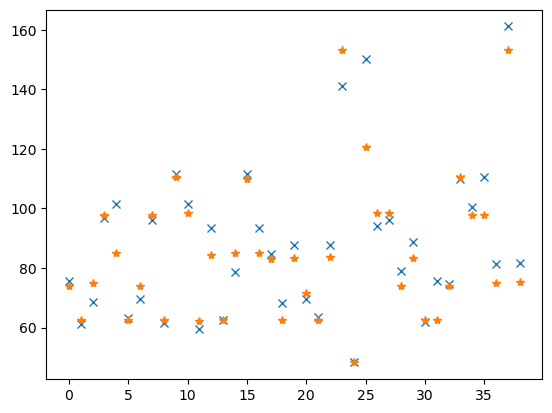

In [34]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [35]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,73.838333
1,61.300000,62.380952
2,68.700000,74.921795
3,96.633333,97.924561
4,101.466667,84.995652
5,63.166667,62.380952
6,69.433333,73.838333
7,96.266667,97.924561
8,61.466667,62.380952
9,111.533333,110.573333


In [36]:
mse = np.mean((y_test.values - y_pred)**2)
mse

56.71119294878774

In [37]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

결과가 나쁘다.

In [ ]:
TPOTRegressor(generations=3, 
              population_size=20, 
              mutation_rate=0.7, 
              crossover_rate=0.3, 
              early_stop=3, 
              max_eval_time_mins=2, 
              verbosity=2, 
              random_state=42, 
              cv=5, 
              n_jobs=-1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

In [ ]:
y_pred = tpot.predict(X_test)
y_pred

In [ ]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [ ]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

In [ ]:
mse = np.mean((y_test.values - y_pred)**2)
mse

In [ ]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

trial2

In [ ]:
print(trial1_Table_dataset.columns)

In [ ]:
trial2_Table_dataset = trial1_Table_dataset.drop( ['Top_LAB_L', 'Top_hls_S'],axis=1)
trial2_Table_dataset

In [ ]:
TPOTRegressor(generations=3, 
              population_size=20, 
              mutation_rate=0.7, 
              crossover_rate=0.3, 
              early_stop=3, 
              max_eval_time_mins=2, 
              verbosity=2, 
              random_state=42, 
              cv=5, 
              n_jobs=-1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

In [ ]:
y_pred = tpot.predict(X_test)
y_pred

In [ ]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [ ]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

In [ ]:
mse = np.mean((y_test.values - y_pred)**2)
mse

In [ ]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()